In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll
)

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

2130


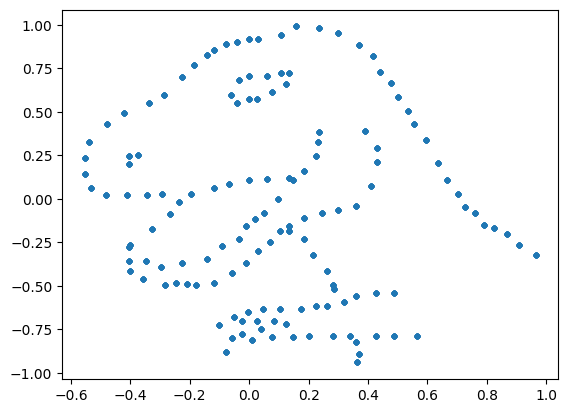

In [11]:
# Try replacing dataset with 'dino', 'bullseye', 'h_lines', 'x_shape', etc. 
dataset = DatasaurusDozen(csv_file='../datasets/DatasaurusDozen.tsv', dataset='dino')
# Or use the SwissRoll dataset
# dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=2130)
print(len(dataset))
plot_batch(next(iter(loader)))